In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pywaffle import Waffle

In [2]:
df = pd.read_csv("dataset.csv")

df.columns = df.columns.str.lower()
df = df.drop(["_id"], axis=1)

df["month"] = pd.to_datetime(df["month"], format = "%b-%y")
df = df.rename(columns = {"month":"date"})

In [3]:
# as suggested in the data description
df_stops = df.copy()
df = df[df.stops == 0]

In [4]:
airline_scores = pd.read_csv("airline_scores.csv")

In [5]:
airline_names_df = set(df['airline'].tolist())
airline_names_scores = airline_scores['airline_name'].tolist()
missing_airlines = [airline for airline in airline_names_df if airline not in airline_names_scores]

# print("missing airline score:", len(missing_airlines))

In [6]:
missing_airlines_mapping = {
    "All Nippon Airways": "ANA All Nippon Airways",
    "Jetstar": "Jetstar Airways",
    "Indonesia AirAsia": "AirAsia",
    "Scoot Tigerair": "Scoot",
    "Thai AirAsia X": "AirAsia",
    "Eva Air": "EVA Air",
    "LATAM Airlines": "LATAM",
    "Virgin Atlantic Airways": "Virgin Atlantic",
    "Citilink Indonesia": "Citilink",
    "Thai Airways International": "Thai Airways",
    "V Australia": "Virgin Australia",
    "Indonesia AirAsia Extra": "AirAsia",
    "AirAsia X": "AirAsia",
}

In [7]:
# feature engingeering add score 
airline_score_mapping = {}
for _, row in airline_scores.iterrows():
    airline_score_mapping[row["airline_name"]] = row["score"]

def get_airline_score(airline):
    if airline in airline_score_mapping:
        return airline_score_mapping[airline]
    elif airline in missing_airlines_mapping:
        return airline_score_mapping[missing_airlines_mapping[airline]]
    else:
        return 1

df["airline_score"] = df["airline"].apply(get_airline_score)

# df

In [8]:
df['avg_seat_per_flight'] = df['max_seats'] / df['all_flights']
df['total_seats'] = df['all_flights'] * df['max_seats']
df['international_city'] = df['international_city'].replace('Palmerston', 'Palmerston North')

In [9]:
# df

# Setup

In [10]:
color_palette = ["#648FFF", "#B2C8FF", "#785EF0", "#BCB0F8", "#DC267F",
                 "#EA7BB1", "#FE6100", "#FFA066", "#FFB000", "#FFDF99"]
blue_color = "#648FFF"
orange_color = "#FE6100"
brown_color = "#634B33"

# Time Series Trends of Flights

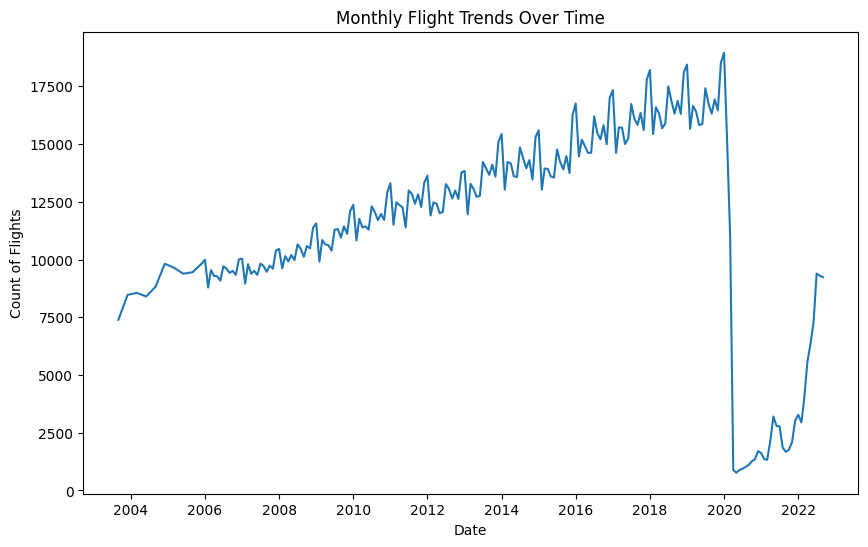

In [11]:
monthly_data = df.groupby(['date']).agg({'all_flights': 'sum'}).reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_data, x='date', y='all_flights')
plt.title('Monthly Flight Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Flights')
plt.show()

# Flight Intensity Heatmap

In [12]:
flight_intensity = df.groupby(['year', 'month_num']).agg({'all_flights':'sum'}).reset_index()
flight_intensity = flight_intensity.pivot(index='year', columns='month_num', values='all_flights')
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
flight_intensity.rename(columns=month_names, inplace=True)
# flight_intensity

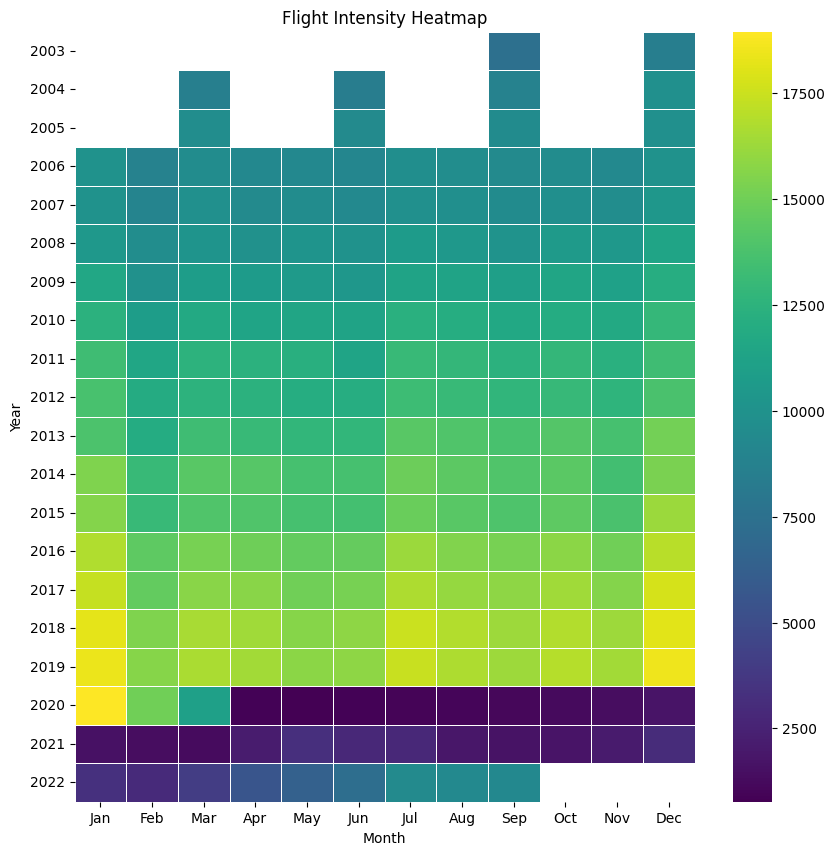

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(flight_intensity, linewidths=0.7, cmap='viridis', linecolor='white')
plt.title('Flight Intensity Heatmap')
plt.xlabel('Month')
plt.ylabel('Year')
plt.yticks(rotation=0)
plt.show()

# I vs O Flights for Australian Cities

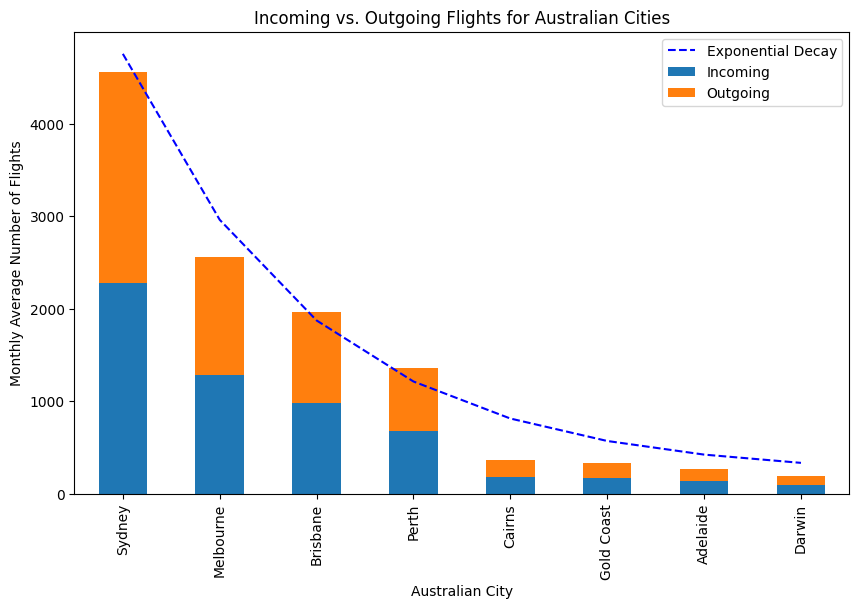

In [14]:
import numpy as np

city_flights = df.groupby(['australian_city', 'in_out', 'date']).agg({'all_flights': 'sum'}).reset_index()
city_flights = city_flights.groupby(['australian_city', 'in_out']).agg({'all_flights': 'mean'}).unstack()
city_flights.columns = city_flights.columns.droplevel()
city_flights['total_flights'] = city_flights.sum(axis=1)
top_8_cities = city_flights.sort_values('total_flights', ascending=False).head(8).drop(columns='total_flights')

top_8_cities.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Incoming vs. Outgoing Flights for Australian Cities')
plt.xlabel('Australian City')
plt.ylabel('Monthly Average Number of Flights')

max_val = top_8_cities.sum(axis=1).max()
min_val = top_8_cities.sum(axis=1).min()
x = np.arange(len(top_8_cities))
y = max_val * np.exp(-0.5 * x) + min_val
plt.plot(x, y, color='blue', linestyle='--', linewidth=1.5, label='Exponential Decay')

plt.legend(['Exponential Decay', 'Incoming', 'Outgoing'])
plt.show()

# Airline Performance

In [15]:
airline_performance = df.groupby('airline').agg({'all_flights': 'sum', 'avg_seat_per_flight': 'mean', 'airline_score':'mean'}).reset_index()

fig = px.scatter(
    airline_performance,
    x='all_flights',
    y='avg_seat_per_flight',
    size='airline_score',
    color='airline',
    title='Airline Performance: Total Flights vs. Average Seats per Flight (2003 - 2022)',
    size_max=70,
    # text='airline',
    color_discrete_sequence=color_palette
)

fig.update_layout(
    xaxis_title='Total Flights',
    yaxis_title='Average Seats per Flight',
    showlegend=False,
    height=700
)

fig.show()

# Route Analysis With Sankey Diagram

In [16]:
import plotly.graph_objects as go

route_data = df.groupby(['port_region', 'australian_city']).agg({'all_flights': 'mean'}).reset_index()

route_data['port_region'] = pd.Categorical(route_data['port_region'], route_data['port_region'].value_counts().index.to_list())
route_data['australian_city'] = pd.Categorical(route_data['australian_city'], route_data['australian_city'].value_counts().index.to_list())
route_data.sort_values(['port_region', 'australian_city'], inplace = True)
route_data = route_data.reset_index(drop=True)

port_regions = route_data['port_region'].unique().tolist()
australian_cities = route_data['australian_city'].unique().tolist()

region_to_index = {region: i for i, region in enumerate(port_regions)}
city_to_index = {city: i + len(port_regions) for i, city in enumerate(australian_cities)}

sources = [region_to_index[row['port_region']] for _, row in route_data.iterrows()]
targets = [city_to_index[row['australian_city']] for _, row in route_data.iterrows()]
values = route_data['all_flights'].tolist()

def hex_to_rgba(hex_color, opacity):
    hex_color = hex_color.lstrip('#')
    return f'rgba({int(hex_color[0:2], 16)}, {int(hex_color[2:4], 16)}, {int(hex_color[4:6], 16)}, {opacity})'

node_color_list = color_palette + [brown_color] * len(city_to_index)
link_colors = [hex_to_rgba(node_color_list[source], 0.5) for source in sources]

labels = port_regions + australian_cities

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=10,
        thickness=15,
        line=dict(width=0.5),
        label=labels,
        color=node_color_list
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors
    )
)])

fig.update_layout(
    title_text="Monthly Average Flights from Airport Regions to Australian Cities",
    width = 1000,
    height = 1000
)

fig.show()

# Route Coverage Map

In [17]:
worldcities_df = pd.read_csv('worldcities.csv')
# worldcities_df

In [18]:
worldcities_df.rename(columns={'city': 'international_city'}, inplace=True)
flights_with_coords = df.merge(worldcities_df[['international_city', 'lat', 'lng']], on=['international_city'], how='left')

flights_with_coords.rename(columns={'lat': 'international_lat', 'lng': 'international_lng'}, inplace=True)
worldcities_df.rename(columns={'international_city': 'australian_city'}, inplace=True)

flights_with_coords = flights_with_coords.merge(worldcities_df[['australian_city', 'lat', 'lng']], on='australian_city', how='left')
flights_with_coords.rename(columns={'lat': 'australian_lat', 'lng': 'australian_lng'}, inplace=True)

unique_flights_with_coords = flights_with_coords.drop_duplicates(subset=['international_city', 'australian_city'])

In [19]:
import plotly.graph_objects as go

fig = go.Figure()

for _, row in unique_flights_with_coords.iterrows():
    fig.add_trace(go.Scattergeo(
        locationmode='ISO-3',
        lon=[row['international_lng'], row['australian_lng']],
        lat=[row['international_lat'], row['australian_lat']],
        mode='lines',
        line=dict(width=1, color='rgba(0, 100, 80, 0.5)'),
        opacity=0.5,
        text=[row['international_city'], row['australian_city']],
        hoverinfo='text+lon+lat'
    ))

for _, row in unique_flights_with_coords.iterrows():
    fig.add_trace(go.Scattergeo(
        locationmode='ISO-3',
        lon=[row['international_lng']],
        lat=[row['international_lat']],
        mode='markers',
        marker=dict(size=4, color='red'),
        text=[row['international_city']],
        hoverinfo='text+lon+lat'
    ))

for _, row in unique_flights_with_coords.iterrows():
    fig.add_trace(go.Scattergeo(
        locationmode='ISO-3',
        lon=[row['australian_lng']],
        lat=[row['australian_lat']],
        mode='markers',
        marker=dict(size=4, color='blue'),
        text=[row['australian_city']],
        hoverinfo='text+lon+lat'
    ))

fig.update_layout(
    title_text='Flight Connections Between International Cities and Australian Cities',
    showlegend=False,
    geo=dict(
        showland=True,
        showcountries=True,
        landcolor='rgb(254, 253, 223)',
        countrycolor='rgb(208, 208, 184)',
        showocean=True,
        oceancolor='rgb(215, 235, 235)',
        projection=dict(
            type='orthographic',
            rotation=dict(
                lon=135,
                lat=-25,
                roll=0
            )
        ),
        showlakes=True,
        lakecolor='rgb(215, 235, 235)',
    ),
    height=700
)

fig.show()

# Most Frequent Route Before Covid (2003-2019)

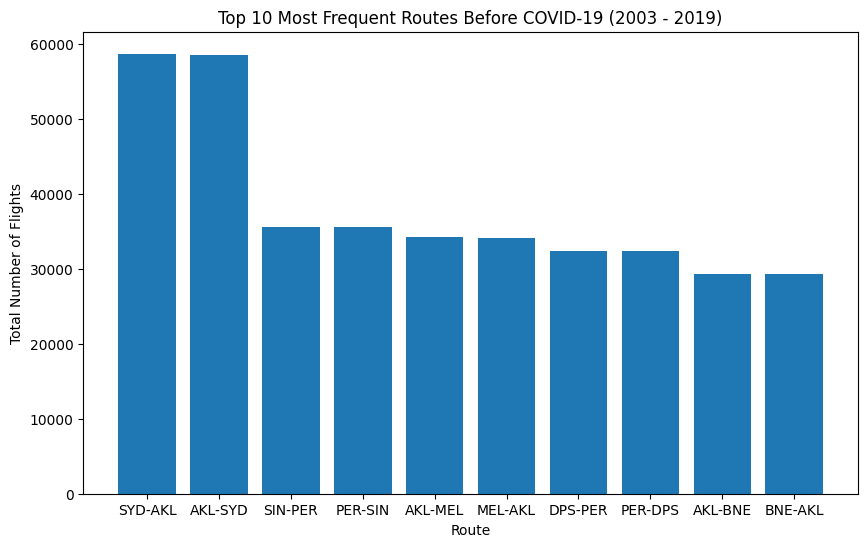

In [20]:
pre_covid_df = df[df['year'] < 2020]
route_aggregation = pre_covid_df.groupby(['route']).agg({'all_flights': 'sum'}).reset_index()
top_routes = route_aggregation.sort_values(by='all_flights', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_routes['route'], top_routes['all_flights'])
plt.xlabel('Route')
plt.ylabel('Total Number of Flights')
plt.title('Top 10 Most Frequent Routes Before COVID-19 (2003 - 2019)')
plt.show()

# After Covid (2020 - 2022)

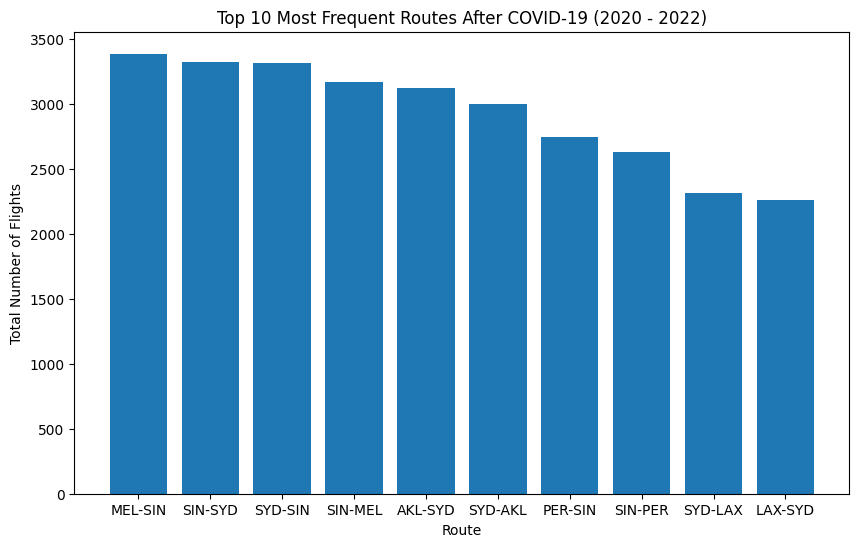

In [21]:
after_covid_df = df[df['year'] >= 2020]
route_aggregation = after_covid_df.groupby(['route']).agg({'all_flights': 'sum'}).reset_index()
top_routes = route_aggregation.sort_values(by='all_flights', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_routes['route'], top_routes['all_flights'])
plt.xlabel('Route')
plt.ylabel('Total Number of Flights')
plt.title('Top 10 Most Frequent Routes After COVID-19 (2020 - 2022)')
plt.show()

# Airline Distribution Per Year

In [22]:
yearly_airline = df.groupby(['year', 'airline']).agg({'all_flights':'sum'}).reset_index()
yearly_airline.loc[yearly_airline['all_flights'] < 2401, 'airline'] = 'Other flights'
yearly_airline['year'] = pd.Categorical(yearly_airline['year'], ordered=True, categories=sorted(yearly_airline['year'].unique()))
yearly_airline = yearly_airline.sort_values(by=['year', 'all_flights'], ascending=[True, False])

fig = px.sunburst(
    yearly_airline,
    path=['year', 'airline'],
    values='all_flights',
    title='Airline Distribution Per Year',
    color='year',
    color_continuous_scale=color_palette
)

fig.update_layout(
    width=1000,
    height=700
)

fig.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# Most Popular Country

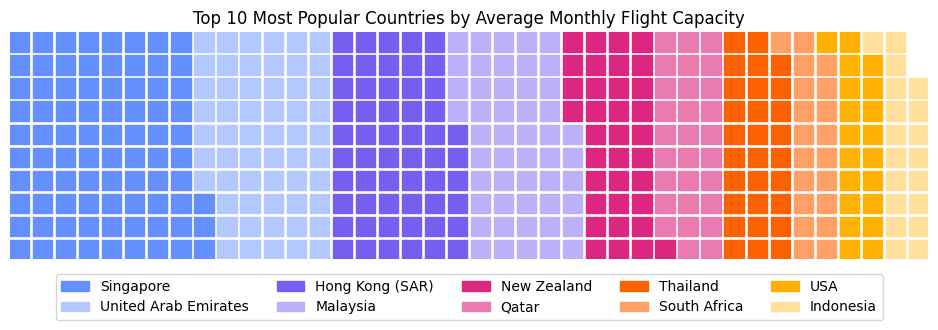

In [23]:
country_avg_flights = df.groupby('port_country')['total_seats'].mean().reset_index()
country_avg_flights = country_avg_flights.sort_values(by='total_seats', ascending=True)

# assuming that the plane is full capacity each time

country_seats_dict = {}

country_avg_flights = country_avg_flights.sort_values(by='total_seats', ascending=False)
for index, row in country_avg_flights[:10].iterrows():
    country = row['port_country']
    total_seats = row['total_seats']
    country_seats_dict[country] = total_seats / 10000

fig = plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    values=country_seats_dict,
    figsize=(10, 6),
    legend={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.3), 'ncol': 5},
    colors=color_palette
)

plt.title("Top 10 Most Popular Countries by Average Monthly Flight Capacity")
plt.show()

# Aircraft Capacity With Distance Relationship

In [24]:
def classify_airplane_type(seat_capacity):
    if seat_capacity <= 50:
        return 'Small Aircraft'
    elif seat_capacity <= 100:
        return 'Regional Aircraft'
    elif seat_capacity <= 200:
        return 'Narrow-body Aircraft'
    elif seat_capacity <= 500:
        return 'Wide-body Aircraft'
    else:
        return 'Very Large Aircraft'
    
df['airplane_type'] = df['avg_seat_per_flight'].apply(classify_airplane_type)
# df

In [25]:
from geopy.distance import geodesic
import numpy as np

distances = []
for _, row in unique_flights_with_coords.iterrows():
    australian_lat = row['australian_lat']
    australian_lng = row['australian_lng']
    international_lat = row['international_lat']
    international_lng = row['international_lng']
    
    if pd.isna(australian_lat) or pd.isna(australian_lng) or pd.isna(international_lat) or pd.isna(international_lng):
        distances.append(np.nan)
        continue
    
    australian_coords = (australian_lat, australian_lng)
    international_coords = (international_lat, international_lng)
    distance = geodesic(australian_coords, international_coords).kilometers
    distances.append(distance)

unique_flights_with_coords['distance'] = distances
distance_df = unique_flights_with_coords[['australian_city', 'international_city', 'distance']]
# distance_df

/var/folders/g9/v8hb1zcs18g4xmhvh5tljh5w0000gn/T/ipykernel_20325/1156218524.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
distances = []
for _, row in df.iterrows():
    australian_city = row['australian_city']
    international_city = row['international_city']
    d = distance_df[(distance_df['australian_city'] == australian_city) & (distance_df['international_city'] == international_city)].head(1)['distance']
    distances.append(d.values[0])

df['distance'] = distances
# df

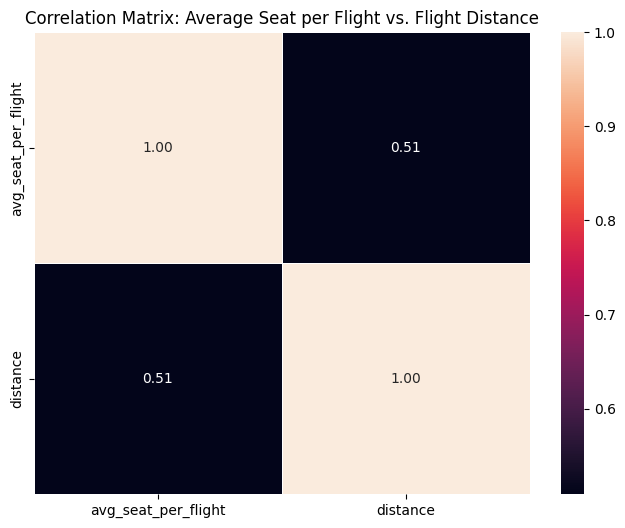

In [27]:
correlation_matrix = df[['avg_seat_per_flight', 'distance']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Average Seat per Flight vs. Flight Distance')
plt.show()

In [28]:
short_cutoff = 2500
medium_cutoff = 7500
long_cutoff = 10000

def categorize_distance(distance):
    if distance <= short_cutoff:
        return 'Short'
    elif distance <= medium_cutoff:
        return 'Medium'
    elif distance <= long_cutoff:
        return 'Long'
    else:
        return 'Very Long'

df['distance_category'] = df['distance'].apply(categorize_distance)
# df


In [29]:
airplane_type_distance = df.groupby(['airplane_type', 'distance_category']).size().reset_index(name='count')

plane_to_index = {plane: i for i, plane in enumerate(np.unique(airplane_type_distance['airplane_type']))}
distance_to_index = {dist: len(plane_to_index) + i for i, dist in enumerate(np.unique(airplane_type_distance['distance_category']))}

sources = [plane_to_index[row['airplane_type']] for _, row in airplane_type_distance.iterrows()]
targets = [distance_to_index[row['distance_category']] for _, row in airplane_type_distance.iterrows()]
values = airplane_type_distance['count'].tolist()
labels = np.unique(airplane_type_distance['airplane_type']).tolist() + np.unique(airplane_type_distance['distance_category']).tolist()

In [30]:
node_color_list = color_palette[:len(labels)]
node_color_list[2], node_color_list[4] = node_color_list[4], node_color_list[2]
link_colors = [hex_to_rgba(node_color_list[source], 0.5) for source in sources]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=10,
        thickness=15,
        line=dict(width=0.5),
        label=labels,
        color=node_color_list
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors
    )
)])

fig.update_layout(
    title_text="Airplane Type to Distance Category",
    width = 1000,
    height = 1000
)

fig.show()